This is the notebook to use to generate a figure. 
For this, you need to have to have the following: 
- the simulated dataset (w3c)
- the set `.env` at the root with `$WORKSPACE` and `$MAPPERTOOLBOX`

## Step 1) run the Mappers on the configs

The following script will generate the Mapper results, shape graphs, plots, and stats for each configuration set in the configuration.
We will run two sets of MapperToolbox configurations (they will run for a while):

```
./code/utils/run_mapper.sh --poolsize 4 mappers_w3c_embed1.json w3c

```


## Step 2) Analyze the created Mappers graphs (circleness, ...)

Once all the mappers have been computed for the configs, you should analyze the shape graphs based on the circleness criteria and the other statistics:

```
CONF=mappers_w3c_embed1.json
```

Run the below for each of the above configurations:

```
source .env
# module load matlab # Maybe run this if you are running in SLURM
COHORT_PATH="$WORKSPACE/data/w3c/cohort.csv"
DATAFOLDER="$WORKSPACE/results/w3c/${CONF}/"
OUTPUT_DIR="$WORKSPACE/results/w3c/analysis/${CONF}/"
ARGS="datafolder='${DATAFOLDER}'; cohort_path='${COHORT_PATH}'; output_dir='${OUTPUT_DIR}';"
matlab -nodesktop -r "${ARGS} run('$WORKSPACE/code/w3c/circle_test_multitiming.m')"

```

For the rest of the criteria, run the following python script:

```
python3 $WORKSPACE/code/utils/cache.py compute_stats \
    $WORKSPACE/data/w3c/cohort.csv \
    $WORKSPACE/results/w3c/${CONF}/ \
    --output_dir $WORKSPACE/results/w3c/analysis/${CONF}/
```

The above two commands will generate tables of stats within `analysis/${CONF}` directory. 

## Step 3) Generate the figures

In [37]:
import csv
import os
import math
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.display import Image as IPyImage, display
from PIL import Image

sns.set_theme(style='white')

# demapper imports for the analysis
from demapper.code.utils.analyze import extract_dataset, get_all_parameters
from demapper.code.utils.config_w3c import DATASETS, FILTERS
from demapper.code.utils.config_mapper import extract_params_f
from demapper.code.utils.utils import filter_dataframe, count_passing, add_col_passing
from demapper.code.utils.plot_grids import plot_grid_params

### Figure (a)

In [38]:
PICKED_DATASET = 'w3c-embed1'

datadir = DATASETS[PICKED_DATASET]
stats_path = os.path.join(datadir, 'compute_stats-combined.csv')
results_path = os.path.join(datadir, 'scores-all.csv')

SBJS = ['SBJ99']
table = {sbj: [] for sbj in SBJS}
for filter_by in FILTERS[PICKED_DATASET]:
    print(filter_by)
    df_fb, max_values = extract_dataset(stats_path, results_path, filter_by, extract_params_f)
            
    target_metrics_limits = {
        'TransitionBetweeness': [0, max_values['TransitionBetweeness'] * 0.99], # Need the data first, add later
        'coverage_nodes': [0.7, 1.0],
        'distances_entropy': [2.0, 10000.0],
        'hrfdur_stat': [0.15, 1.0],
    }
    
    if 'tSNE' in filter_by:
        df_fb['embed'] = df_fb.apply(lambda row: 'tSNE p={}'.format(row['perplexity']), axis=1)
    
        
    embedVals = df_fb['embed'].drop_duplicates().to_numpy()
    KVals = df_fb['K'].drop_duplicates().to_numpy()
    
    for sbj in SBJS:
        for embed in embedVals:
            df_e = filter_dataframe(df_fb, {'embed': [embed] })
            KVals = df_e['K'].drop_duplicates().to_numpy()
            for k in KVals:
                fdf = filter_dataframe(df_fb, {'embed': [embed], 'K': [k], 'SBJ': [sbj] })
                cnt = count_passing(fdf, target_metrics_limits)
                table[sbj].append({
                    'embed': embed,
                    'K': k,
                    'count': cnt,
                    'perc': cnt / len(fdf) * 100.0,
                    'total': len(fdf),
                    'Embedding type': 'Non-Parametric' if filter_by == 'EmbedBDLMapperWtd' else 'Parametric'
                })

df = pd.DataFrame(data=table[SBJS[0]])

EmbedBDLMapperWtd
len(stats):  4250
len(results):  4250
tSNEBDLMapperWtd
len(stats):  4250
len(results):  4250
KEmbedBDLMapper
len(stats):  4250
len(results):  4250


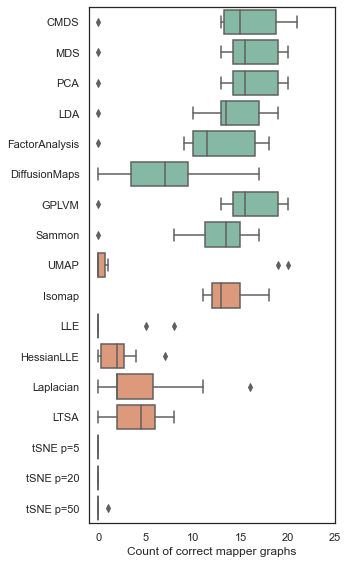

In [91]:
order = [
 'CMDS',
 'MDS',
 'PCA',
 'LDA',
 'FactorAnalysis',
 'DiffusionMaps',
 'GPLVM',
 'Sammon',
 'UMAP',
 'Isomap',
 'LLE',
 'HessianLLE',
 'Laplacian',
 'LTSA',
 'tSNE p=5',
 'tSNE p=20',
 'tSNE p=50',]

cols = (['#7DC0A7'] * 8) + (['#ED936B'] * (len(order)- 8))

plt.figure(figsize=(5,8))
g = sns.boxplot(data=df, x='count', y='embed', order=order, palette=cols)#, palette='Set2')
plt.xlim([-1, 25])
plt.legend([], frameon=False)
plt.ylabel('')
plt.xlabel('Count of correct mapper graphs')
# plt.grid(alpha=0.1)
plt.tight_layout()
savefig_path = os.path.join(
        datadir, 'embeds_analysis.png')
plt.savefig(savefig_path, dpi=150)
plt.show()

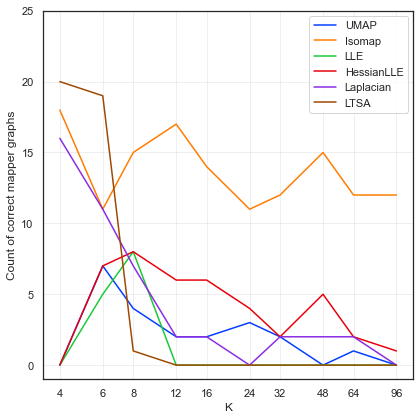

In [92]:
embeds = ['UMAP',
 'Isomap',
 'LLE',
 'HessianLLE',
 'Laplacian',
 'LTSA']

plt.figure(figsize=(6,6))
ax = None
# for e in embeds:
fdf = filter_dataframe(df, {'embed': embeds})
ax = sns.lineplot(data=fdf, x='K', y='count', hue='embed', ax=ax, palette='bright', markers=['*']*(len(embeds)))

ax.set(xscale='log')
k_vals = sorted(fdf['K'].drop_duplicates().tolist())
ax.set(xticks=k_vals)
ax.set(xticklabels=k_vals)
plt.ylabel('Count of correct mapper graphs')
plt.ylim([-1, 25])
plt.grid(alpha=0.3)
plt.legend(embeds)
plt.tight_layout()
savefig_path = os.path.join(
        datadir, 'parametric_results.png')
plt.savefig(savefig_path, dpi=150)
plt.show()

### Figure (d)

In [5]:

mapper_config = 'mappers_w3c_bins1.json'

basepath = os.path.abspath('.').split('demapper')[0]
main_path = '{}/demapper/results/w3c/{}/'.format(basepath, mapper_config)
res_path = '{}/demapper/results/w3c/analysis/{}/'.format(basepath, mapper_config)

fname = 'plot_task-G.png'
sbjs = sorted([s for s in os.listdir(main_path) if s.startswith('SBJ')])
mappers = sorted([[m] + [int(k) for k in m.split('_')[1:]]
                  for m in os.listdir(os.path.join(main_path, sbjs[0]))
                  if 'Mapper' in m])

df = pd.DataFrame(data=mappers, columns=['mapper', 'K', 'R', 'G'])

In [6]:

for KVal in [20]:
    df1 = df[df['K'] == KVal]
    RVals = df1['R'].drop_duplicates()[::-1]
    GVals = df1['G'].drop_duplicates()

    plot_grid_params(df1, sbjs[0], fname, 'G', GVals, 'R', RVals, main_path, res_path, prefix='K{}-'.format(KVal))

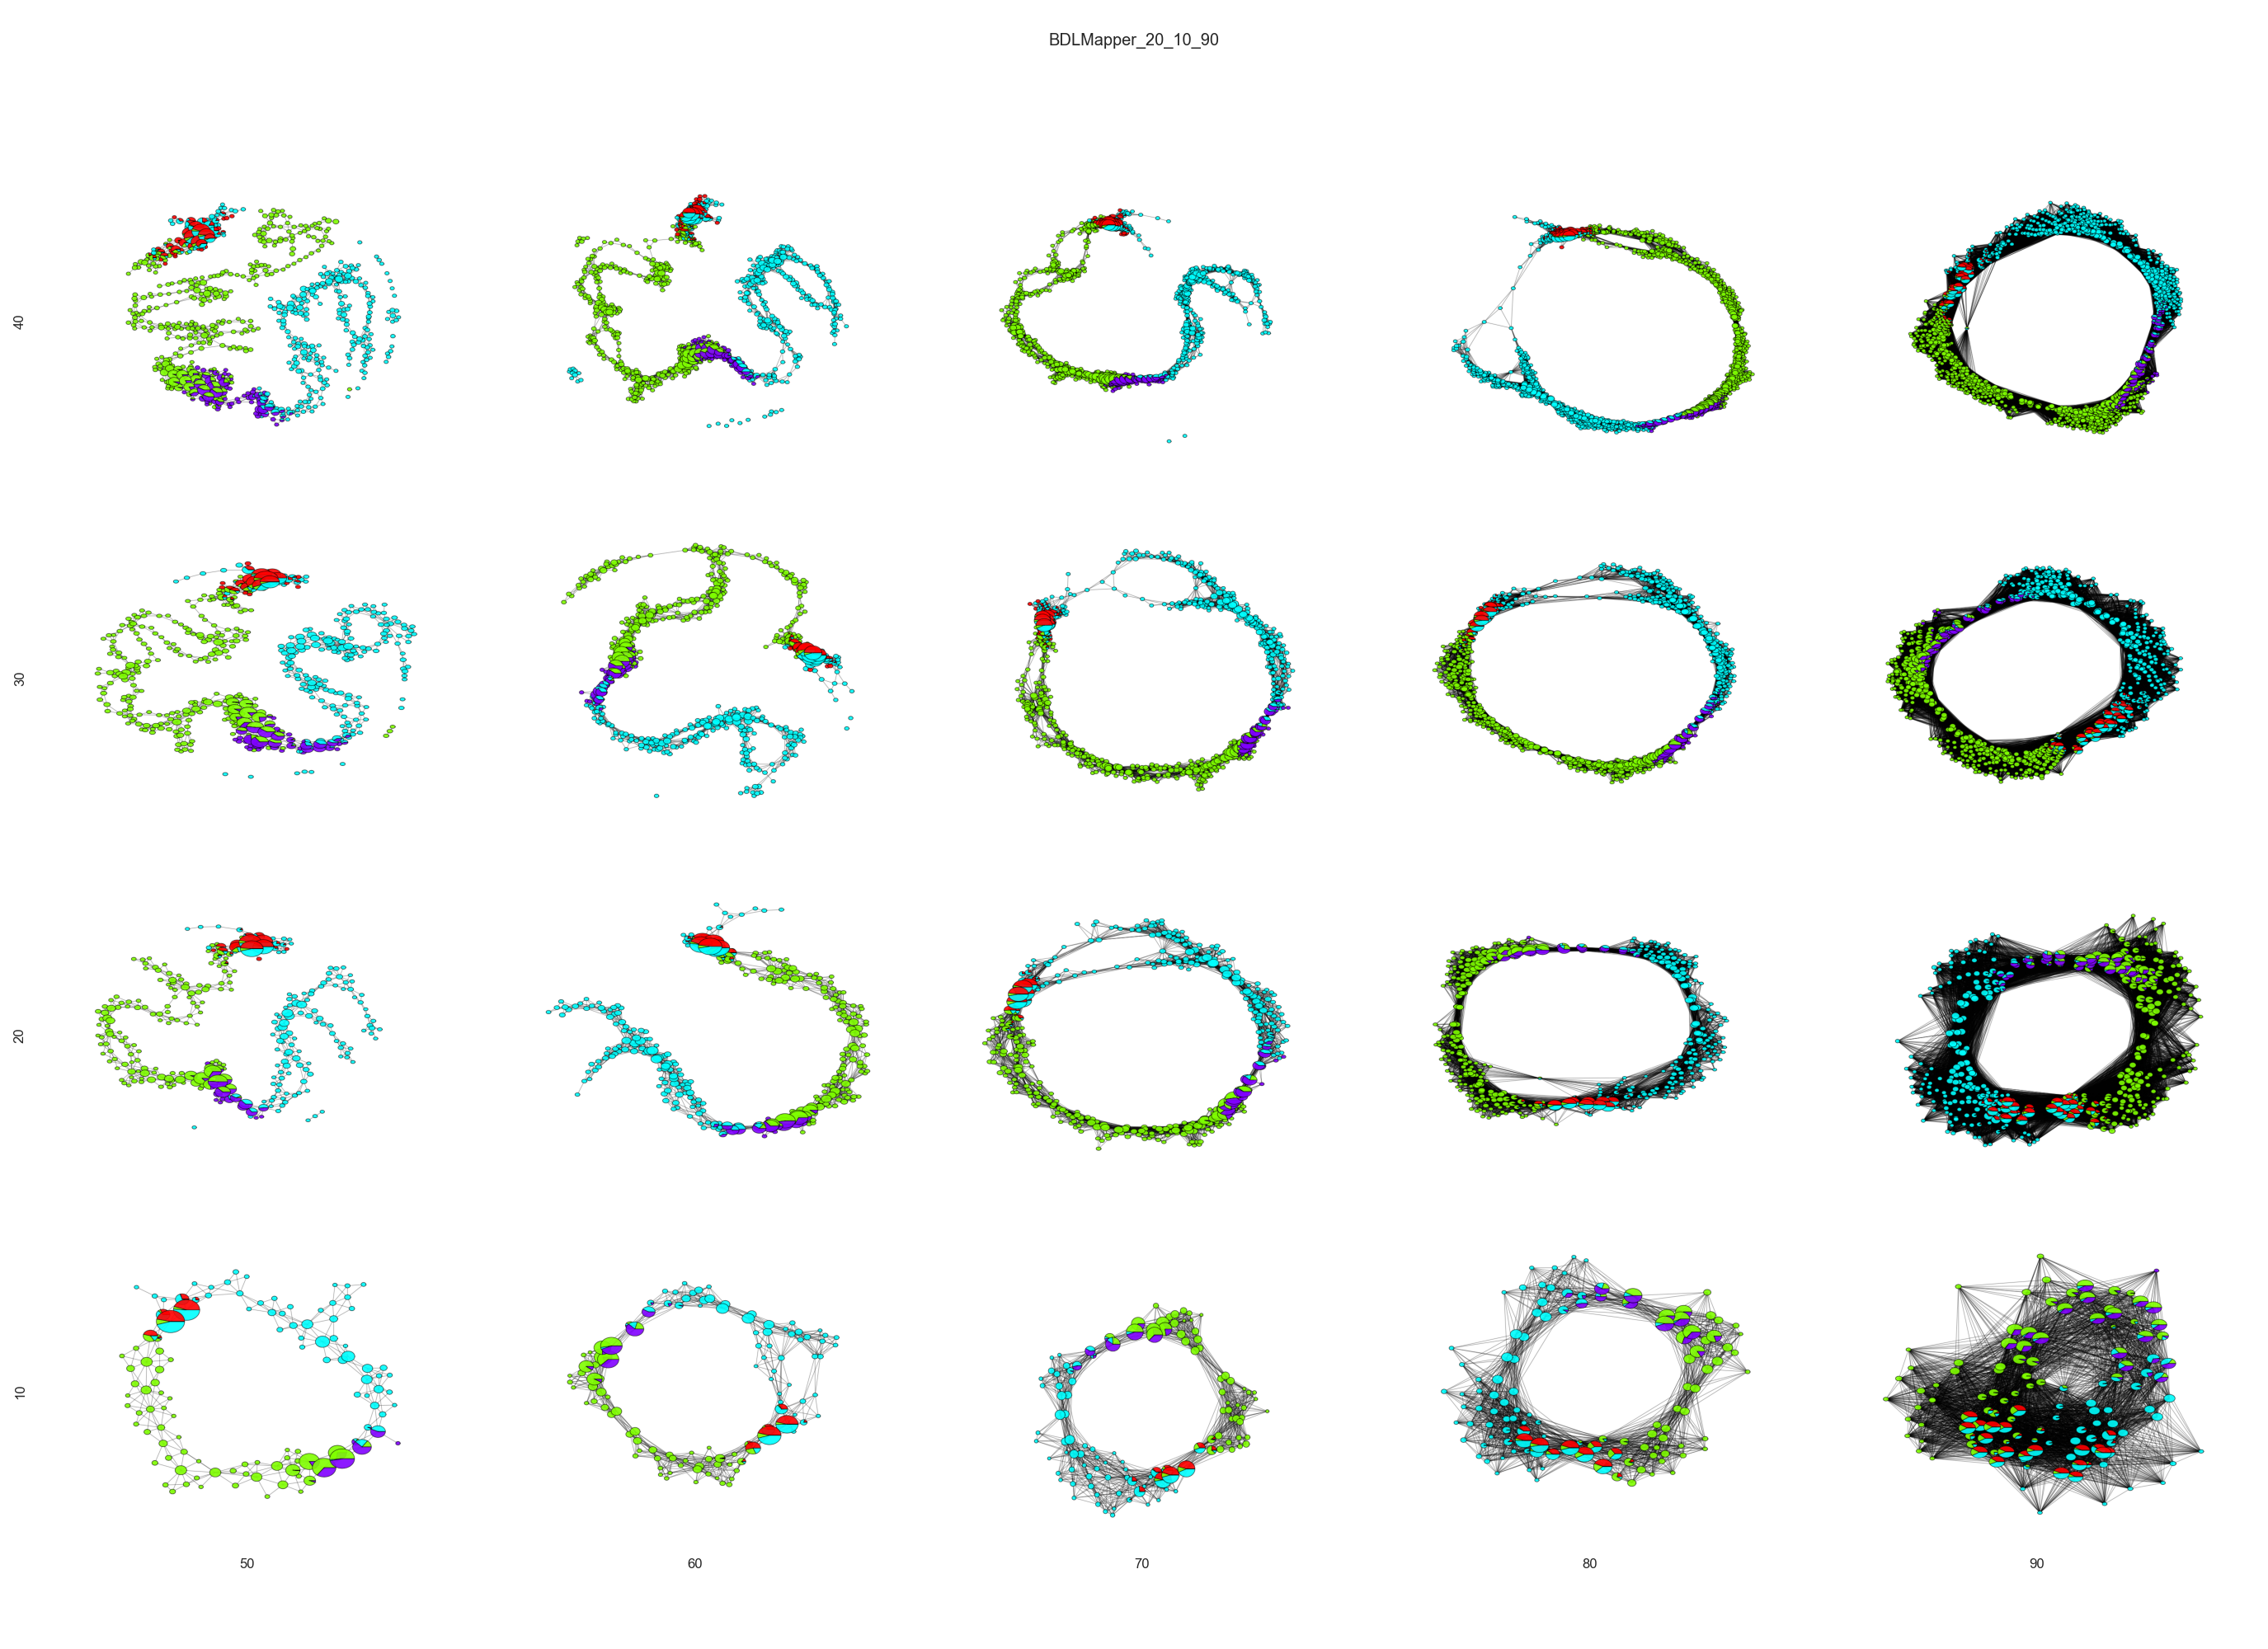

In [7]:
imgpath = 'results/w3c/analysis/mappers_w3c_bins1.json/SBJ99-K20-plot_task-G.png'
display(IPyImage(filename=os.path.join('../', imgpath)))

#### Selecting the shape graphs that pass the circleness criterion
Figure 3d above is missing the boxes that select which Mapper shape graphs pass the criteria defined for correctly extracted topological features. 

To select for the parameters that pass, we have the following code that uses the analyzed data and plot a heatmap 

In [8]:
PICKED_DATASET = 'w3c-bins1'

datadir = DATASETS[PICKED_DATASET]
stats_path = os.path.join(datadir, 'compute_stats-combined.csv')
results_path = os.path.join(datadir, 'scores-all.csv')

filter_by = FILTERS[PICKED_DATASET][0]
df, max_values = extract_dataset(stats_path, results_path, filter_by, extract_params_f)

resdir = datadir
if len(FILTERS[PICKED_DATASET]) > 1:
    resdir = os.path.join(datadir, filter_by)
    os.makedirs(resdir, exist_ok=True)

all_sbjs, sbjs_map = get_all_parameters(df, PICKED_DATASET)

print(max_values)
df.sample(5)

len(stats):  20
len(results):  20
Total 1 subjects:
SBJ99
Extra combinations:
{'CircleLoss': 59.7333333333334, 'TransitionBetweeness': 4.0}


,Mapper,SBJ,K,R,G,CircleLoss,TransitionBetweeness,coverage_nodes,coverage_TRs,hrfdur_stat,distances_max,distances_entropy,assortativity,degree_TRs_avg,degree_TRs_entropy
6,BDLMapper_20_20_60,SBJ99,20,20,60,11.680000,4.0,1.000000,1.000000,0.327815,28.0,4.36513,0.096425,89.8338,5.74722
19,BDLMapper_20_40_90,SBJ99,20,40,90,0.066811,0.0,1.000000,1.000000,0.606876,7.0,2.64119,0.283399,8178.9100,7.30063
8,BDLMapper_20_20_80,SBJ99,20,20,80,0.114719,0.0,1.000000,1.000000,0.515513,8.0,2.75544,0.268091,636.7590,5.72378
12,BDLMapper_20_30_70,SBJ99,20,30,70,0.157343,1.0,1.000000,1.000000,0.309603,16.0,3.82960,0.046930,290.2920,6.80398
16,BDLMapper_20_40_60,SBJ99,20,40,60,23.608034,4.0,0.963952,0.988602,0.197597,53.0,5.37017,-0.021461,127.5810,6.96821


In [9]:
# We define the criteria for inclusion and exclusion to the analysis!
target_metrics_limits = {
    'TransitionBetweeness': [0, max_values['TransitionBetweeness'] * 0.99], # Need the data first, add later
    'coverage_nodes': [0.7, 1.0],
    'distances_entropy': [2.0, 10000.0],
    'hrfdur_stat': [0.15, 1.0],
}

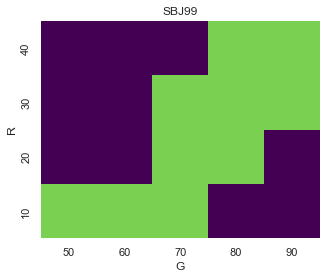

In [10]:
# Then we find the parameteres that pass all the critera
sbj = all_sbjs[0]
fdf = filter_dataframe(df, {'K': [20], 'SBJ': [sbj]})

fdf = add_col_passing(fdf, target_metrics_limits)
fdf = fdf.pivot(index='R', columns='G', values='passing').sort_values('R', ascending=False)
fdf = fdf * 0.8

plt.figure(figsize=(5,4))
ax = sns.heatmap(fdf, cbar=False, vmax=1.0, cmap=sns.color_palette("viridis", as_cmap=True))
plt.title(sbj)
plt.show()

The above heatmap can be used to draw the green rectangles on figure 3d

### Figure (e)

In [11]:
# Import the dataset analysis tables generated during step 2
PICKED_DATASET = 'w3c-bins2'

datadir = DATASETS[PICKED_DATASET]
stats_path = os.path.join(datadir, 'compute_stats-combined.csv')
results_path = os.path.join(datadir, 'scores-all.csv')

filter_by = FILTERS[PICKED_DATASET][0]
df, max_values = extract_dataset(stats_path, results_path, filter_by, extract_params_f)

resdir = datadir
if len(FILTERS[PICKED_DATASET]) > 1:
    resdir = os.path.join(datadir, filter_by)
    os.makedirs(resdir, exist_ok=True)

all_sbjs, sbjs_map = get_all_parameters(df, PICKED_DATASET)

print(max_values)
df.sample(5)

len(stats):  448
len(results):  448
Total 1 subjects:
SBJ99
Extra combinations:
{'CircleLoss': 96.5200686106346, 'TransitionBetweeness': 14.0}


,Mapper,SBJ,K,R,G,CircleLoss,TransitionBetweeness,n_nodes,coverage_nodes,coverage_TRs,hrfdur_stat,distances_max,distances_entropy,assortativity,degree_TRs_avg,degree_TRs_entropy
392,BDLMapper_70_15_20,SBJ99,70,15,20,96.520069,14.0,151.0,0.264901,0.409118,0.271523,13.0,3.22690,0.089342,9.12597,3.93990
17,BDLMapper_10_20_30,SBJ99,10,20,30,26.750000,14.0,207.0,0.859903,0.977804,0.222222,54.0,5.43632,0.081194,11.44750,4.27483
275,BDLMapper_50_20_50,SBJ99,50,20,50,20.166667,14.0,275.0,1.000000,1.000000,0.269091,48.0,5.25093,0.251761,28.00000,4.36298
78,BDLMapper_20_15_80,SBJ99,20,15,80,0.025245,0.0,247.0,1.000000,1.000000,0.651822,6.0,2.40521,0.315091,471.92900,5.20005
428,BDLMapper_70_35_60,SBJ99,70,35,60,96.520069,14.0,578.0,0.832180,0.628074,0.247405,40.0,4.91569,0.060519,119.69900,6.77884


In [12]:
# We define the criteria for inclusion and exclusion to the analysis!
target_metrics_limits = {
    'TransitionBetweeness': [0, max_values['TransitionBetweeness'] * 0.99], # Need the data first, add later
    'coverage_nodes': [0.7, 1.0],
    'distances_entropy': [2.0, 10000.0],
    'hrfdur_stat': [0.15, 1.0],
}


In [13]:
# Generate the plot
sbj = all_sbjs[0] # only one here

KVals = sorted(df['K'].drop_duplicates().tolist())

added = None
for kval in KVals:
    fdf = filter_dataframe(df, {'K': [kval], 'SBJ': [sbj]})
    fdf = add_col_passing(fdf, target_metrics_limits)
    fdf = fdf.pivot(index='R', columns='G', values='passing').sort_values('R', ascending=False)
    fdf = fdf * 1.0
    if added is None:
        added = fdf
    else:
        added = added + fdf

# Get average
added = added / len(KVals)

# Generate figure
plt.figure(figsize=(6, 4))
ax = sns.heatmap(added, vmax=1.0)
plt.title(sbj)
plt.xlabel('Gain')
plt.ylabel('Resolution')
plt.title('')
plt.tight_layout()
plt.savefig(os.path.join(resdir,'plot_mergerRG_SBJ99.png'), dpi=150)
# plt.show()
plt.close()

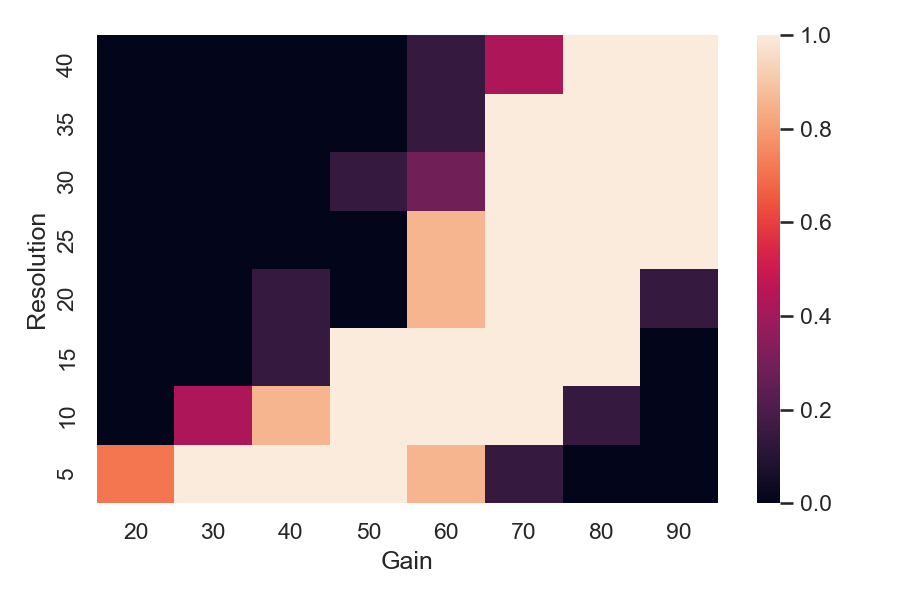

In [14]:
imgpath = 'results/w3c/analysis/mappers_w3c_bins2.json/plot_mergerRG_SBJ99.png'
display(IPyImage(filename=os.path.join('../', imgpath)))

### Stats

<AxesSubplot:xlabel='G', ylabel='R'>

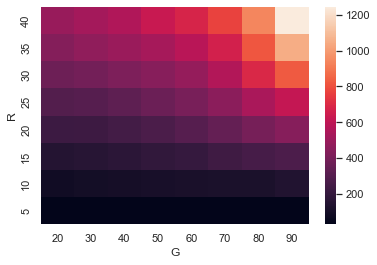

In [15]:
grouped = df.groupby(['R', 'G'], as_index=True)['n_nodes'].mean().reset_index()
grouped = grouped.pivot(index='R', columns='G', values='n_nodes').sort_values('R', ascending=False)
sns.heatmap(grouped)

<AxesSubplot:xlabel='R', ylabel='n_nodes'>

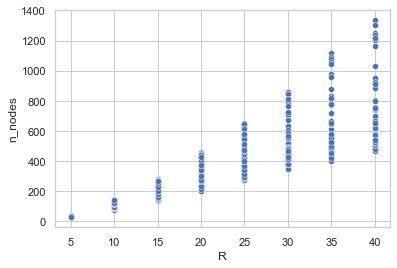

In [16]:
sns.scatterplot(data=df, x='R', y='n_nodes')

In [17]:
from scipy.stats import pearsonr
xs = df['R'].tolist()
ys = df['n_nodes'].tolist()
pearsonr(xs,ys)

(0.8687192448897398, 3.5562959005628797e-138)

In [18]:
from scipy.stats import pearsonr
xs = df['G'].tolist()
ys = df['n_nodes'].tolist()
pearsonr(xs,ys)

(0.36172432525372394, 2.6988198505454346e-15)

(0.9385590165867268, 0.0005534569228445016)

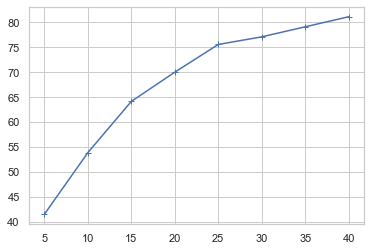

In [19]:
KVals = sorted(df['K'].drop_duplicates().tolist())

ntbl = []
for kval in KVals:
    fdf = filter_dataframe(df, {'K': [kval], 'SBJ': [sbj]})
    fdf = add_col_passing(fdf, target_metrics_limits)
    ntbl.append(fdf[fdf['passing'] == True][['R', 'G']])
    
ntbl = pd.concat(ntbl)
avgs = ntbl.groupby('R')['G'].mean()
Rs = avgs.index.tolist()
Gs = avgs.tolist()
plt.plot(Rs, Gs, '-+')
pearsonr(Rs, Gs)